In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use("ggplot")
sns.set_style("dark")

In [2]:
# !mkdir -p data
# %pip install kaggle
# !kaggle datasets download -d parisrohan/credit-score-classification -p data/

In [3]:
!unzip -u data/credit-score-classification.zip -d data

Archive:  data/credit-score-classification.zip


In [4]:
train_df = pd.read_csv("data/train.csv", decimal=".", engine="python") \
.sample(1000, random_state=42) # working on a slow laptop
test_df = pd.read_csv("data/test.csv", decimal=".", engine="python")
train_df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
75721,0x1d1af,CUS_0x3539,February,an Arakalid,30,995-31-4669,Manager,43391.96,3688.996667,1,...,Good,1468.28,29.112468,23 Years and 8 Months,No,0.000000,53.969385063055675,High_spent_Large_value_payments,554.9302816036111,Good
80184,0x1ebd6,CUS_0x8716,January,Matthewz,18,185-99-8068,Scientist,14351.21,NaN,8,...,Bad,4766.87,39.849732,NaN,Yes,61.098718,118.08021357217683,Low_spent_Small_value_payments,238.3144849566528,Poor
19864,0x8a66,CUS_0x21dc,January,Tom Miless,41,241-53-8475,Developer,130125.04,10871.753333,5,...,Good,1195.05,21.542892,15 Years and 11 Months,No,204.285650,1255.8993022448951,Low_spent_Small_value_payments,NaN,Good
76699,0x1d769,CUS_0x32d3,April,Lisaa,35,204-78-6176,Manager,20107.21,1631.600833,6,...,Standard,2544.6,32.423759,19 Years and 4 Months,Yes,27.106395,66.81977464950728,Low_spent_Small_value_payments,359.23391378882377,Poor
92991,0x236dd,CUS_0xadad,August,Masond,27,027-11-6852,Doctor,92186.19,7487.182500,1,...,Good,809.01,39.543131,20 Years and 9 Months,No,185.797654,115.52003931707223,High_spent_Medium_value_payments,697.4005568630175,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16783,0x7855,CUS_0x8ae5,August,NaN,37_,396-24-8172,Entrepreneur,34884.34,2633.028333,8,...,Standard,2162.63,37.849879,NaN,Yes,67.036984,82.44032755928549,High_spent_Medium_value_payments,363.82552148440084,Standard
41130,0x10700,CUS_0xa267,March,Nicolae,46,242-22-1951,Doctor,129727.4,11076.616667,3,...,Standard,1111.92,40.041892,31 Years and 1 Months,Yes,175.056341,532.1017055435334,Low_spent_Large_value_payments,670.5036204239769,Standard
78318,0x1e0e4,CUS_0xa75c,July,Brownn,39,981-43-7537,Manager,56483.64,4900.970000,8,...,_,213.93,31.654046,22 Years and 11 Months,No,87.742193,__10000__,High_spent_Medium_value_payments,596.8259799881209,Poor
72169,0x1bcdf,CUS_0xbaa8,February,Kate Holtone,54,850-41-4179,Accountant,77963.9,6711.991667,4,...,_,1441.62,31.125400,26 Years and 8 Months,No,136.825947,474.5729097249793,Low_spent_Large_value_payments,329.8003099890679,Good


# EDA
Objective: Start by getting a basic understanding of the dataset. This includes checking the data types of columns, identifying missing values (NaNs), and understanding the overall structure of the data.

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 75721 to 4151
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        1000 non-null   object 
 1   Customer_ID               1000 non-null   object 
 2   Month                     1000 non-null   object 
 3   Name                      923 non-null    object 
 4   Age                       1000 non-null   object 
 5   SSN                       1000 non-null   object 
 6   Occupation                1000 non-null   object 
 7   Annual_Income             1000 non-null   object 
 8   Monthly_Inhand_Salary     845 non-null    float64
 9   Num_Bank_Accounts         1000 non-null   int64  
 10  Num_Credit_Card           1000 non-null   int64  
 11  Interest_Rate             1000 non-null   int64  
 12  Num_of_Loan               1000 non-null   object 
 13  Type_of_Loan              885 non-null    object 
 14  Delay_fro

How many unique clients do we have?

In [6]:
train_df["ID"].value_counts()

ID
0x1d1af    1
0x3a06     1
0x17c2f    1
0x1af3a    1
0x24e48    1
          ..
0x1d004    1
0xc421     1
0xf834     1
0x1d9e8    1
0x2e51     1
Name: count, Length: 1000, dtype: int64

Identifying columns that are incorrectly typed (e.g., numerical data stored as strings) and casting them to the correct data types. This is important for accurate analysis and modeling.

In [7]:
problem_columns_float = [
    "Annual_Income",
    "Changed_Credit_Limit",
    "Outstanding_Debt",
    "Total_EMI_per_month",
    "Amount_invested_monthly",
    "Monthly_Balance",
]
train_df[problem_columns_float]

,Annual_Income,Changed_Credit_Limit,Outstanding_Debt,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
75721,43391.96,10.72,1468.28,0.000000,53.969385063055675,554.9302816036111
80184,14351.21,21.91,4766.87,61.098718,118.08021357217683,238.3144849566528
19864,130125.04,3.82,1195.05,204.285650,1255.8993022448951,NaN
76699,20107.21,10.4,2544.6,27.106395,66.81977464950728,359.23391378882377
92991,92186.19,9.74,809.01,185.797654,115.52003931707223,697.4005568630175
...,...,...,...,...,...,...
16783,34884.34,7.52,2162.63,67.036984,82.44032755928549,363.82552148440084
41130,129727.4,11.68,1111.92,175.056341,532.1017055435334,670.5036204239769
78318,56483.64,6.72,213.93,87.742193,__10000__,596.8259799881209
72169,77963.9,2.34,1441.62,136.825947,474.5729097249793,329.8003099890679


In [8]:
train_df[problem_columns_float] = train_df[problem_columns_float].apply(
    pd.to_numeric, errors="coerce"
)
train_df[problem_columns_float] = train_df[problem_columns_float].astype("float64")
train_df.loc[:, problem_columns_float].fillna(
    value=train_df[problem_columns_float].median(),
    inplace=True,
)
train_df[problem_columns_float]

,Annual_Income,Changed_Credit_Limit,Outstanding_Debt,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
75721,43391.96,10.72,1468.28,0.000000,53.969385,554.930282
80184,14351.21,21.91,4766.87,61.098718,118.080214,238.314485
19864,130125.04,3.82,1195.05,204.285650,1255.899302,NaN
76699,20107.21,10.40,2544.60,27.106395,66.819775,359.233914
92991,92186.19,9.74,809.01,185.797654,115.520039,697.400557
...,...,...,...,...,...,...
16783,34884.34,7.52,2162.63,67.036984,82.440328,363.825521
41130,129727.40,11.68,1111.92,175.056341,532.101706,670.503620
78318,56483.64,6.72,213.93,87.742193,NaN,596.825980
72169,77963.90,2.34,1441.62,136.825947,474.572910,329.800310


In [9]:
problem_columns_int = ["Num_of_Loan", "Num_of_Delayed_Payment", "Age"]
train_df[problem_columns_int]

,Num_of_Loan,Num_of_Delayed_Payment,Age
75721,0,6,30
80184,6,17,18
19864,2,0,41
76699,2,13,35
92991,4,0,27
...,...,...,...
16783,4,14,37_
41130,2,15,46
78318,3,19,39
72169,3,8,54


In [10]:
train_df[problem_columns_int] = train_df[problem_columns_int].apply(
    pd.to_numeric, errors="coerce"
)
train_df[problem_columns_int] = train_df[problem_columns_int].astype(pd.Int32Dtype())
train_df.loc[:, problem_columns_int].fillna(
    value=train_df[problem_columns_int].median(), inplace=True
)
train_df[problem_columns_int]

,Num_of_Loan,Num_of_Delayed_Payment,Age
75721,0,6,30
80184,6,17,18
19864,2,0,41
76699,2,13,35
92991,4,0,27
...,...,...,...
16783,4,14,<NA>
41130,2,15,46
78318,3,19,39
72169,3,8,54


Prepare separate variables for different column types:

In [11]:
number_columns = train_df.select_dtypes("number").columns
categorical_columns = train_df.select_dtypes("object").columns.drop("Credit_Score")
feature_columns = categorical_columns.union(number_columns)
target = train_df["Credit_Score"]
number_columns, categorical_columns

(Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
        'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
        'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
        'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
        'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance'],
       dtype='object'),
 Index(['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Occupation',
        'Type_of_Loan', 'Credit_Mix', 'Credit_History_Age',
        'Payment_of_Min_Amount', 'Payment_Behaviour'],
       dtype='object'))

In [12]:
train_df.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,956.0,9.140000e+02,845.000000,1000.000000,1000.000000,1000.000000,959.0,1000.000000,894.0,977.000000,980.000000,993.000000,1000.000000,1000.000000,927.000000,987.000000
mean,100.953975,1.278416e+05,4062.246902,19.956000,29.244000,73.852000,2.74244,21.041000,25.061521,10.572334,22.766327,1408.363746,32.221520,1291.435872,182.991274,409.473343
std,654.333664,1.038219e+06,3053.717336,132.481566,151.175065,484.844759,60.814954,14.905015,201.093894,6.622470,171.093340,1107.999417,5.105133,8391.380526,187.106243,212.887491
min,-500.0,7.019435e+03,421.085833,0.000000,1.000000,1.000000,-100.0,-5.000000,-3.0,-2.240000,0.000000,0.560000,21.542892,0.000000,10.357888,1.700934
25%,25.0,1.920757e+04,1584.788750,4.000000,4.000000,8.000000,1.0,10.000000,9.0,5.900000,3.000000,589.890000,27.997808,27.766807,66.918802,275.041909
50%,34.0,3.597424e+04,3046.300000,5.500000,5.000000,14.000000,3.0,17.000000,14.0,9.520000,6.000000,1154.590000,32.046308,64.065977,122.064250,341.462759
75%,42.0,7.180845e+04,5836.960000,8.000000,7.000000,21.000000,5.0,28.000000,18.0,15.010000,9.000000,1970.440000,36.358562,140.706887,220.673732,491.361067
max,8569.0,1.888455e+07,14771.740000,1647.000000,1420.000000,5771.000000,1416.0,65.000000,4185.0,32.920000,2551.000000,4987.190000,46.591820,78530.000000,1255.899302,1418.676158


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 75721 to 4151
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        1000 non-null   object 
 1   Customer_ID               1000 non-null   object 
 2   Month                     1000 non-null   object 
 3   Name                      923 non-null    object 
 4   Age                       956 non-null    Int32  
 5   SSN                       1000 non-null   object 
 6   Occupation                1000 non-null   object 
 7   Annual_Income             914 non-null    float64
 8   Monthly_Inhand_Salary     845 non-null    float64
 9   Num_Bank_Accounts         1000 non-null   int64  
 10  Num_Credit_Card           1000 non-null   int64  
 11  Interest_Rate             1000 non-null   int64  
 12  Num_of_Loan               959 non-null    Int32  
 13  Type_of_Loan              885 non-null    object 
 14  Delay_fro

## Some outliers

Identify and address outliers in the dataset, such as negative values where they don't make sense (e.g., age cannot be negative), or unrealistic values like an age of 8698.

In [14]:
train_df = train_df.drop(
    train_df[
        (train_df["Age"] < 0)
        | (train_df["Age"] > 100)
        | (train_df["Num_Bank_Accounts"] < 0)
        | (train_df["Num_of_Loan"] < 0)
        | (train_df["Num_of_Delayed_Payment"] < 0)
        | (train_df["Delay_from_due_date"] < 0)
    ].index
)
train_df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
75721,0x1d1af,CUS_0x3539,February,an Arakalid,30,995-31-4669,Manager,43391.96,3688.996667,1,...,Good,1468.28,29.112468,23 Years and 8 Months,No,0.000000,53.969385,High_spent_Large_value_payments,554.930282,Good
80184,0x1ebd6,CUS_0x8716,January,Matthewz,18,185-99-8068,Scientist,14351.21,NaN,8,...,Bad,4766.87,39.849732,NaN,Yes,61.098718,118.080214,Low_spent_Small_value_payments,238.314485,Poor
19864,0x8a66,CUS_0x21dc,January,Tom Miless,41,241-53-8475,Developer,130125.04,10871.753333,5,...,Good,1195.05,21.542892,15 Years and 11 Months,No,204.285650,1255.899302,Low_spent_Small_value_payments,NaN,Good
76699,0x1d769,CUS_0x32d3,April,Lisaa,35,204-78-6176,Manager,20107.21,1631.600833,6,...,Standard,2544.60,32.423759,19 Years and 4 Months,Yes,27.106395,66.819775,Low_spent_Small_value_payments,359.233914,Poor
92991,0x236dd,CUS_0xadad,August,Masond,27,027-11-6852,Doctor,92186.19,7487.182500,1,...,Good,809.01,39.543131,20 Years and 9 Months,No,185.797654,115.520039,High_spent_Medium_value_payments,697.400557,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16783,0x7855,CUS_0x8ae5,August,NaN,<NA>,396-24-8172,Entrepreneur,34884.34,2633.028333,8,...,Standard,2162.63,37.849879,NaN,Yes,67.036984,82.440328,High_spent_Medium_value_payments,363.825521,Standard
41130,0x10700,CUS_0xa267,March,Nicolae,46,242-22-1951,Doctor,129727.40,11076.616667,3,...,Standard,1111.92,40.041892,31 Years and 1 Months,Yes,175.056341,532.101706,Low_spent_Large_value_payments,670.503620,Standard
78318,0x1e0e4,CUS_0xa75c,July,Brownn,39,981-43-7537,Manager,56483.64,4900.970000,8,...,_,213.93,31.654046,22 Years and 11 Months,No,87.742193,NaN,High_spent_Medium_value_payments,596.825980,Poor
72169,0x1bcdf,CUS_0xbaa8,February,Kate Holtone,54,850-41-4179,Accountant,77963.90,6711.991667,4,...,_,1441.62,31.125400,26 Years and 8 Months,No,136.825947,474.572910,Low_spent_Large_value_payments,329.800310,Good


## Various plots
Using visualizations like box plots and pie charts to get insights into the distribution of data, detect outliers, and understand categorical distributions.

### Box plots

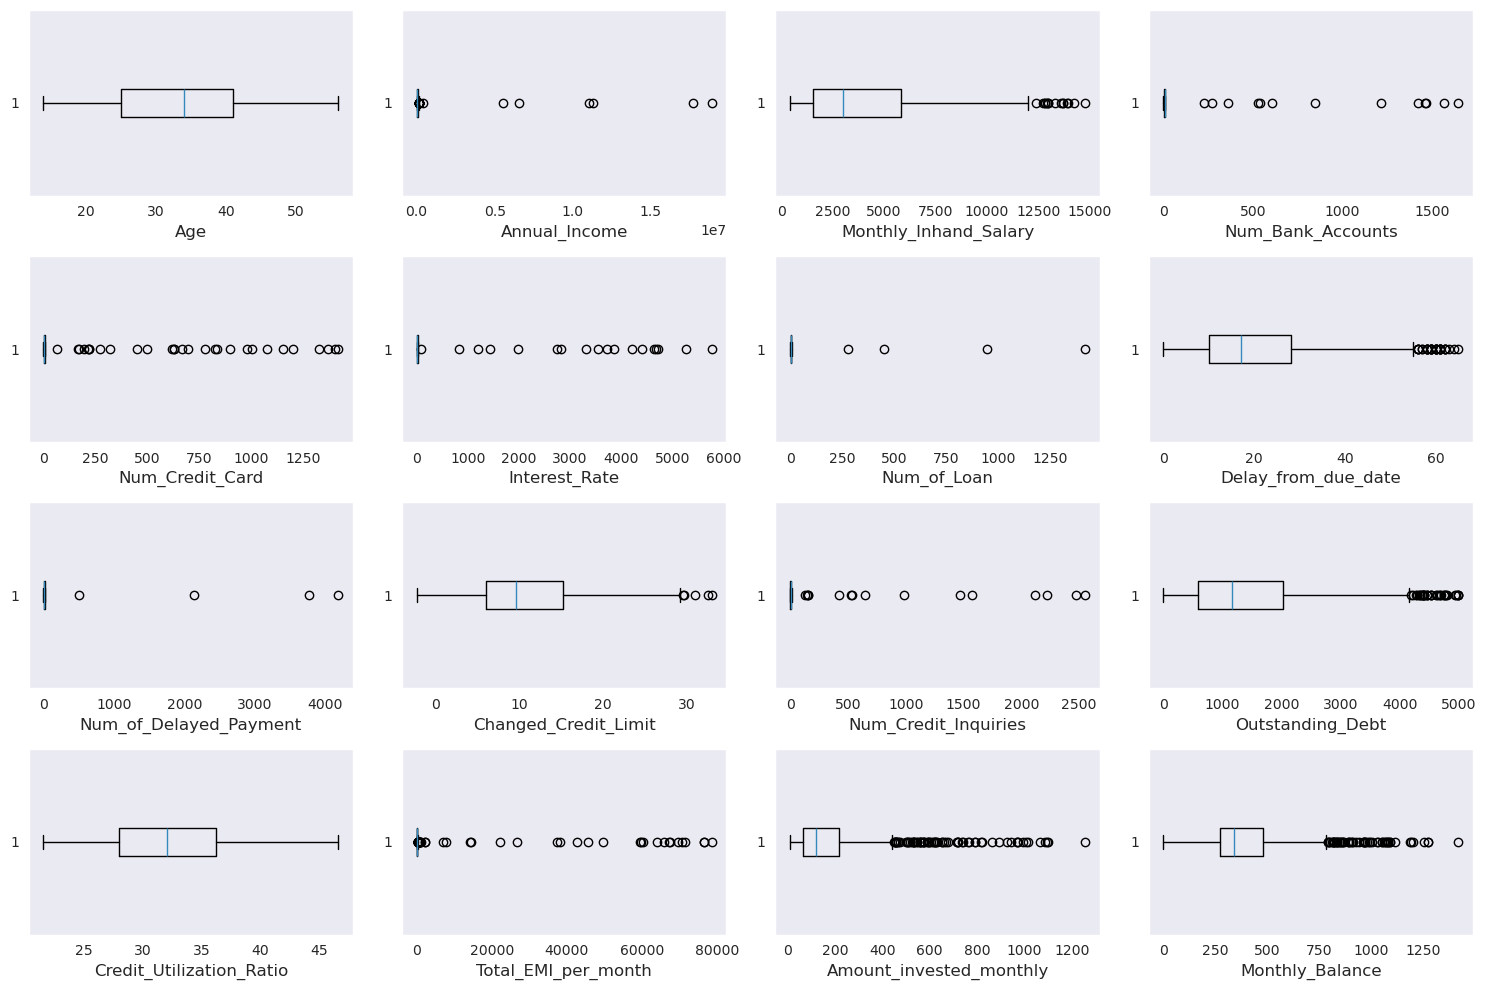

In [15]:
box_data = train_df[
    number_columns
]

nrows = 4

fig, axes = plt.subplots(nrows, len(number_columns)//nrows, figsize=(15, 10))

for i, column in enumerate(box_data.columns):
    row = i // (len(number_columns) // nrows)  
    col = i % (len(number_columns) // nrows) 


    non_nan_data = box_data[column].dropna()
    axes[row, col].boxplot(non_nan_data, vert=False)
    axes[row, col].set_xlabel(column)

plt.tight_layout()
plt.show()

This box plot shows that there are many outliers (points outside the whiskers), indicating possible data issues or extreme variability.

### Pie charts

In [16]:
train_df[
    [
        "Month",
        "Occupation",
        "Type_of_Loan",
        "Credit_Mix",
        "Payment_of_Min_Amount",
        "Payment_Behaviour",
        "Credit_Score",
    ]
].value_counts()

Month     Occupation    Type_of_Loan                                                                                                                                                                 Credit_Mix  Payment_of_Min_Amount  Payment_Behaviour                 Credit_Score
January   Engineer      Payday Loan                                                                                                                                                                  Good        No                     High_spent_Medium_value_payments  Good            2
April     Accountant    Credit-Builder Loan                                                                                                                                                          Good        No                     High_spent_Medium_value_payments  Good            1
June      Engineer      Payday Loan                                                                                                                      

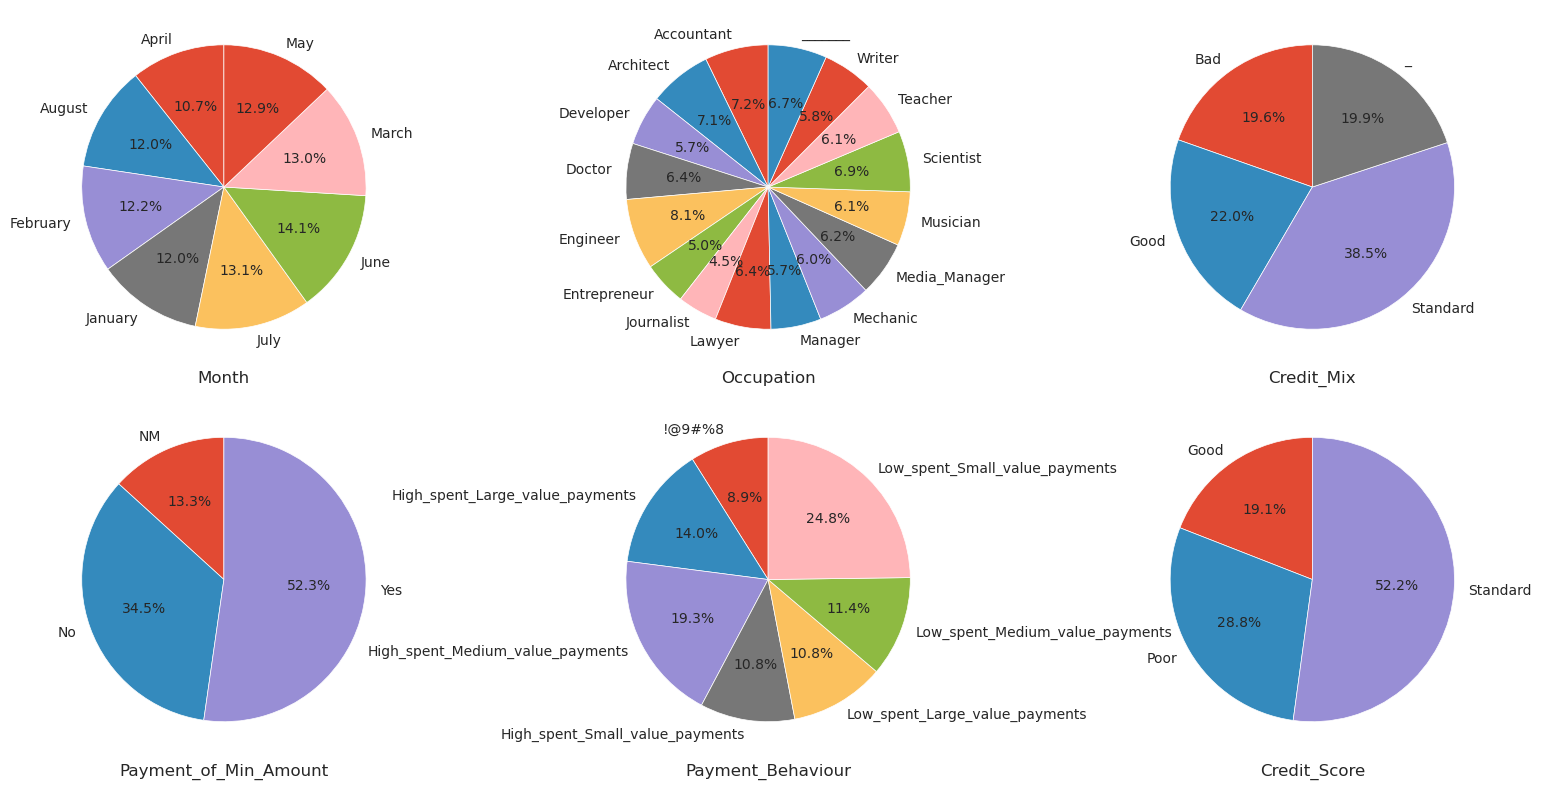

In [17]:
pie_data = train_df[
    [
        "Month",
        "Occupation",
        "Credit_Mix",
        "Payment_of_Min_Amount",
        "Payment_Behaviour",
        "Credit_Score",
    ]
]

nrows = 2
ncols = 3  
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8))

for i, column in enumerate(pie_data.columns):
    row = i // ncols
    col = i % ncols

    grouped_data = pie_data.groupby(column).size().reset_index(name="counts")

    # Extract data for the pie chart
    labels = grouped_data[column]
    sizes = grouped_data["counts"]

    # Plot pie chart in the correct subplot
    axes[row, col].pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
    axes[row, col].set_xlabel(column)

plt.tight_layout()
plt.show()

This pie chart shows the distribution of categories within 'categorical_column'. It reveals that some categories dominate the dataset, while others are underrepresented.

#### Donut charts (nested pie charts)

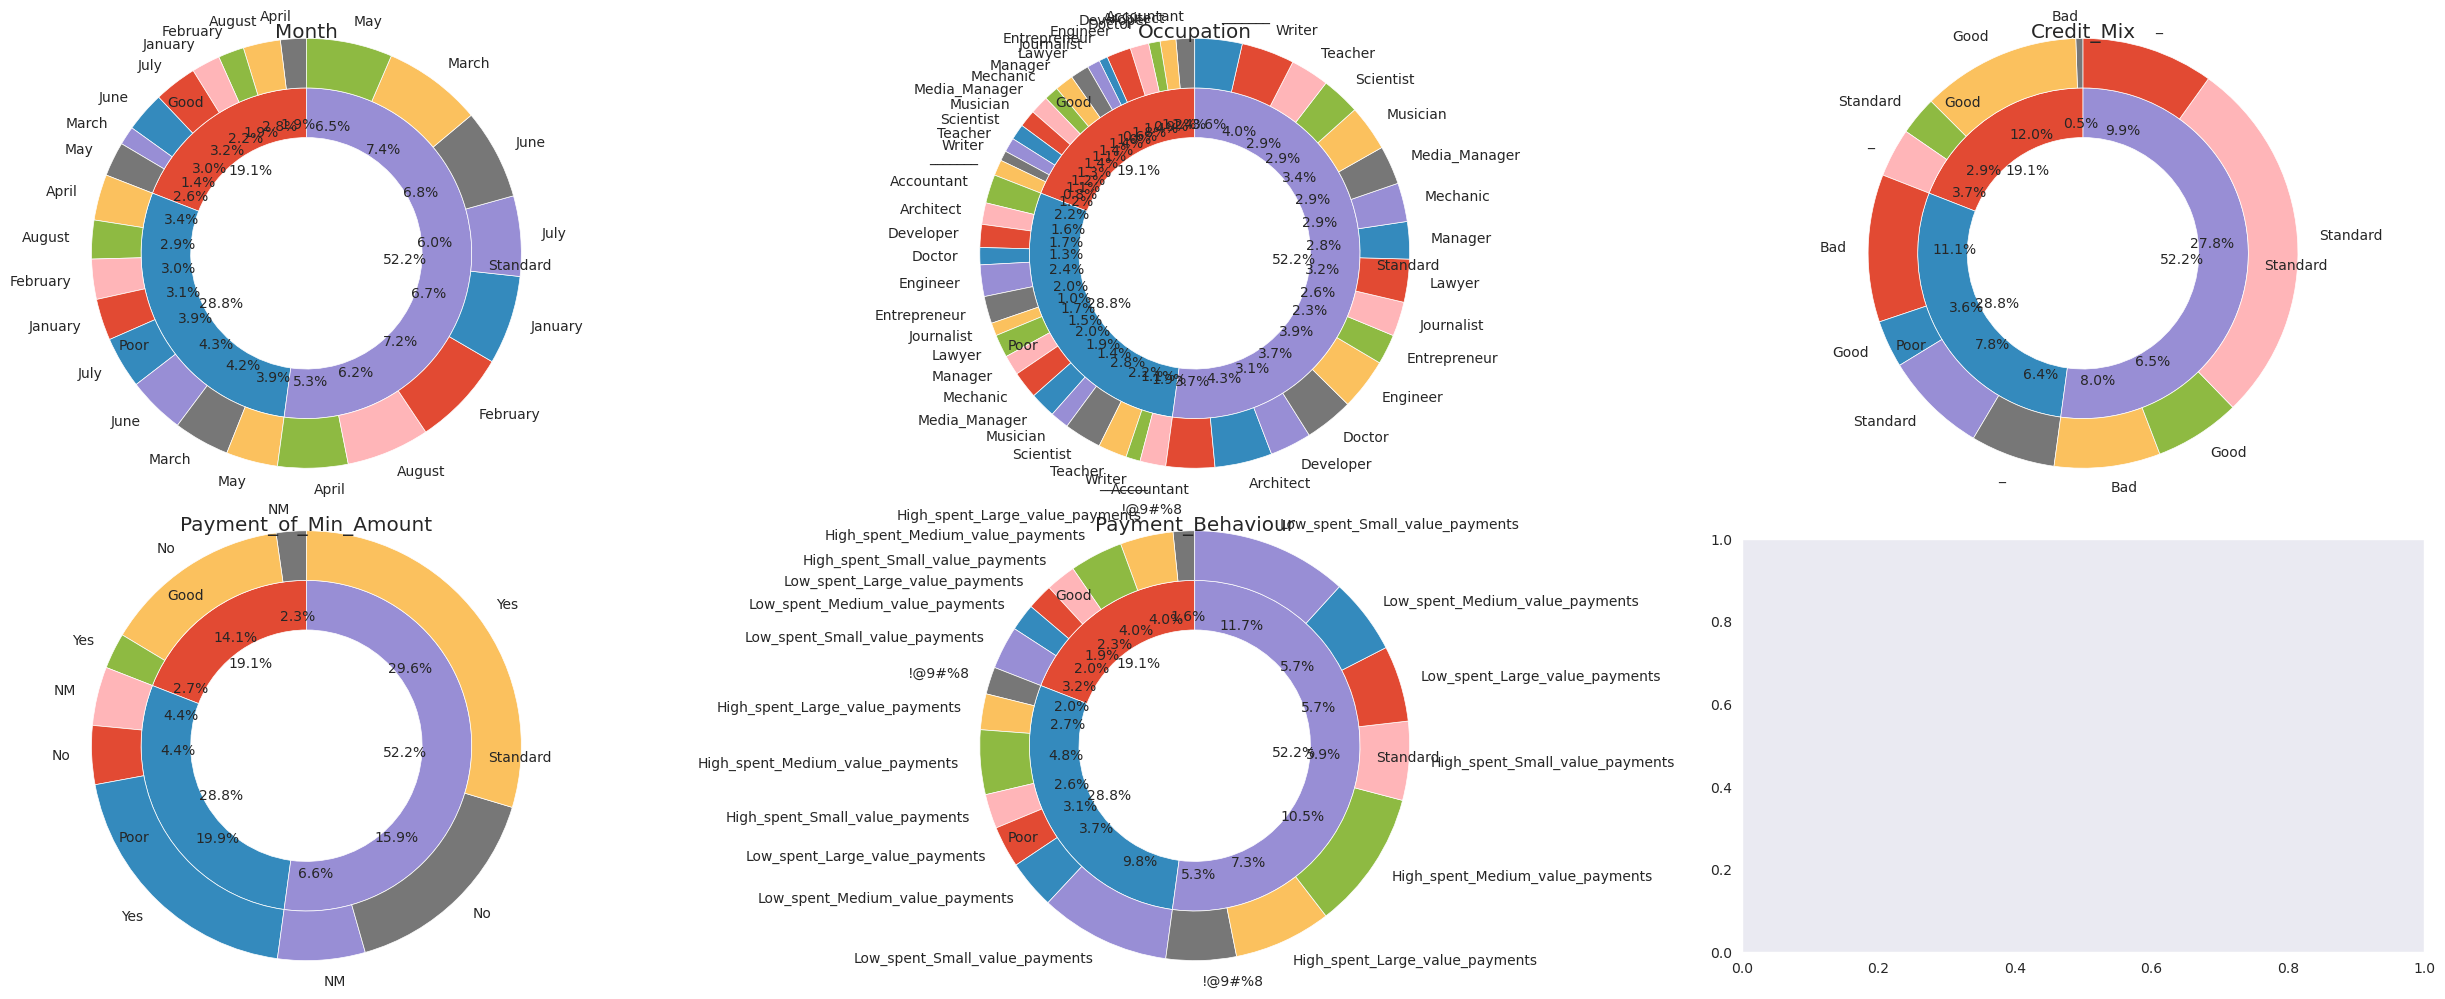

In [18]:
pie_data = train_df[
    [
        "Month",
        "Occupation",
        "Credit_Mix",
        "Payment_of_Min_Amount",
        "Payment_Behaviour",
        "Credit_Score",
    ]
]

# Group by 'Credit_Score' for the inner layer
inner_group = pie_data.groupby('Credit_Score').size().reset_index(name='counts')
inner_labels = inner_group['Credit_Score']
inner_sizes = inner_group['counts']

# Define the outer layers (columns other than 'Credit_Score')
outer_columns = ["Month", "Occupation", "Credit_Mix", "Payment_of_Min_Amount", "Payment_Behaviour"]

nrows = 2
ncols = 3

fig, axes = plt.subplots(nrows, ncols, figsize=(25, 10))

for i, column in enumerate(outer_columns):
    outer_group = pie_data.groupby(['Credit_Score', column]).size().reset_index(name='counts')
    
    row = i // ncols
    col = i % ncols

    # Create the outer labels and sizes based on the groups
    outer_labels = outer_group[column]
    outer_sizes = outer_group['counts']
    
    # Create the donut chart
    axes[row, col].pie(inner_sizes, labels=inner_labels, radius=1, wedgeprops=dict(width=0.3, edgecolor='w'), autopct="%1.1f%%", startangle=90)
    axes[row, col].pie(outer_sizes, labels=outer_labels, radius=1.3, wedgeprops=dict(width=0.3, edgecolor='w'), autopct="%1.1f%%", startangle=90)
    
    # Add title for the outer layer
    axes[row, col].set_title(column)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Dealing with Missing Values & Feature Extraction
**Objective**: Identify columns with missing values and decide how to handle them (e.g., drop, fill, or impute). Also, extract new features from existing data to enhance the dataset.

Finding nulls in data:

In [19]:
train_df.isnull().sum()

ID                            0
Customer_ID                   0
Month                         0
Name                         69
Age                          44
SSN                           0
Occupation                    0
Annual_Income                84
Monthly_Inhand_Salary       142
Num_Bank_Accounts             0
Num_Credit_Card               0
Interest_Rate                 0
Num_of_Loan                  38
Type_of_Loan                105
Delay_from_due_date           0
Num_of_Delayed_Payment       94
Changed_Credit_Limit         23
Num_Credit_Inquiries         16
Credit_Mix                    0
Outstanding_Debt              7
Credit_Utilization_Ratio      0
Credit_History_Age           87
Payment_of_Min_Amount         0
Total_EMI_per_month           0
Amount_invested_monthly      67
Payment_Behaviour             0
Monthly_Balance              11
Credit_Score                  0
dtype: int64

The 'Name' column is not crucial for our analysis since we have 'ID' as a unique identifier. We can safely drop the 'Name' column.

In [20]:
def delete_col(cols):
    """
    Drops a specified column from the DataFrame and its associated index variable.
    """
    global train_df, categorical_columns, number_columns
    train_df.drop(columns=cols, inplace=True)

    for col in cols:
        if col in categorical_columns:
            categorical_columns = categorical_columns.drop(col)
        else:
            number_columns = number_columns.drop(col)


delete_col(["Name", "Customer_ID", "SSN"])

Although usage of `nonlocal` is not recommended, in this case it is okay.

In [21]:
train_df["Credit_History_Age"].value_counts()

Credit_History_Age
19 Years and 8 Months     8
16 Years and 3 Months     8
8 Years and 3 Months      8
17 Years and 9 Months     7
17 Years and 11 Months    7
                         ..
13 Years and 8 Months     1
28 Years and 5 Months     1
6 Years and 3 Months      1
19 Years and 5 Months     1
31 Years and 1 Months     1
Name: count, Length: 320, dtype: int64

### Transforming `Credit_History_Age`

In [22]:
train_df["Credit_History_Age"]

75721     23 Years and 8 Months
80184                       NaN
19864    15 Years and 11 Months
76699     19 Years and 4 Months
92991     20 Years and 9 Months
                  ...          
16783                       NaN
41130     31 Years and 1 Months
78318    22 Years and 11 Months
72169     26 Years and 8 Months
4151      16 Years and 3 Months
Name: Credit_History_Age, Length: 928, dtype: object

Convert the `Credit_History_Age` column to a int format to facilitate analysis and avoid creating too many columns during one-hot encoding.

In [23]:
split_credit_history = train_df["Credit_History_Age"].str.extract(
    r"(\d+)\sYears\sand\s(\d+)\sMonths"
)

total_months = split_credit_history[0].astype(
    pd.Int32Dtype()
) * 12 + split_credit_history[1].astype(pd.Int32Dtype())

train_df["Credit_History_Age"] = total_months
total_months

75721     284
80184    <NA>
19864     191
76699     232
92991     249
         ... 
16783    <NA>
41130     373
78318     275
72169     320
4151      195
Length: 928, dtype: Int32

### Handling `Type_of_Loan`
By splitting and exploding 'Type_of_Loan', we can handle cases where a single individual has multiple loans, making the data more granular and accurate for analysis.

In [24]:
train_df["Type_of_Loan"].value_counts().head(20)

Type_of_Loan
Not Specified                                       21
Credit-Builder Loan                                 17
Personal Loan                                       15
Payday Loan                                         15
Home Equity Loan                                    14
Mortgage Loan                                       13
Student Loan                                         9
Debt Consolidation Loan                              8
Mortgage Loan, and Student Loan                      6
Auto Loan                                            6
Credit-Builder Loan, and Mortgage Loan               5
Credit-Builder Loan, and Home Equity Loan            5
Payday Loan, and Personal Loan                       5
Personal Loan, and Student Loan                      4
Personal Loan, and Debt Consolidation Loan           4
Home Equity Loan, and Mortgage Loan                  4
Credit-Builder Loan, and Debt Consolidation Loan     3
Personal Loan, and Home Equity Loan                 

In [25]:
loan_types = [
    "Not Specified",
    "Credit-Builder Loan",
    "Personal Loan",
    "Debt Consolidation Loan",
    "Student Loan",
    "Payday Loan",
    "Mortgage Loan",
    "Auto Loan",
    "Home Equity Loan",
]

train_df["Type_of_Loan"].fillna("", inplace=True)
for suffix in loan_types:
    train_df["Type_of_Loan_" + suffix] = train_df["Type_of_Loan"].apply(
        lambda x: suffix in x.split(", ")
    )

delete_col(["Type_of_Loan"])

/tmp/ipykernel_158297/65363886.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df["Type_of_Loan"].fillna("", inplace=True)


In [26]:
train_df

,ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Credit_Score,Type_of_Loan_Not Specified,Type_of_Loan_Credit-Builder Loan,Type_of_Loan_Personal Loan,Type_of_Loan_Debt Consolidation Loan,Type_of_Loan_Student Loan,Type_of_Loan_Payday Loan,Type_of_Loan_Mortgage Loan,Type_of_Loan_Auto Loan,Type_of_Loan_Home Equity Loan
75721,0x1d1af,February,30,Manager,43391.96,3688.996667,1,5,10,0,...,Good,False,False,False,False,False,False,False,False,False
80184,0x1ebd6,January,18,Scientist,14351.21,NaN,8,7,18,6,...,Poor,True,False,True,False,True,False,True,False,False
19864,0x8a66,January,41,Developer,130125.04,10871.753333,5,2,11,2,...,Good,False,False,False,False,False,False,True,False,False
76699,0x1d769,April,35,Manager,20107.21,1631.600833,6,6,32,2,...,Poor,False,True,False,False,False,False,False,False,False
92991,0x236dd,August,27,Doctor,92186.19,7487.182500,1,2,12,4,...,Good,True,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16783,0x7855,August,<NA>,Entrepreneur,34884.34,2633.028333,8,4,30,4,...,Standard,False,False,False,False,True,False,True,False,False
41130,0x10700,March,46,Doctor,129727.40,11076.616667,3,451,19,2,...,Standard,False,False,True,False,False,False,False,False,False
78318,0x1e0e4,July,39,Manager,56483.64,4900.970000,8,3,10,3,...,Poor,True,False,False,False,False,False,True,False,False
72169,0x1bcdf,February,54,Accountant,77963.90,6711.991667,4,4,8,3,...,Good,False,False,False,False,False,False,True,False,True


In [27]:
categorical_columns = categorical_columns.drop("Credit_History_Age")
number_columns = number_columns.append(pd.Index(["Credit_History_Age"]))
number_columns, categorical_columns

(Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
        'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
        'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
        'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
        'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance',
        'Credit_History_Age'],
       dtype='object'),
 Index(['ID', 'Month', 'Occupation', 'Credit_Mix', 'Payment_of_Min_Amount',
        'Payment_Behaviour'],
       dtype='object'))

In [28]:
train_df = pd.get_dummies(
    train_df,
    columns=[
        "Month",
        "Occupation",
        "Credit_Mix",
        "Payment_of_Min_Amount",
        "Payment_Behaviour",
    ],
    drop_first=True,
)
train_df = pd.get_dummies(train_df, columns=["Credit_Score"])
train_df

,ID,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Payment_of_Min_Amount_Yes,Payment_Behaviour_High_spent_Large_value_payments,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments,Credit_Score_Good,Credit_Score_Poor,Credit_Score_Standard
75721,0x1d1af,30,43391.96,3688.996667,1,5,10,0,9,6,...,False,True,False,False,False,False,False,True,False,False
80184,0x1ebd6,18,14351.21,NaN,8,7,18,6,18,17,...,True,False,False,False,False,False,True,False,True,False
19864,0x8a66,41,130125.04,10871.753333,5,2,11,2,3,0,...,False,False,False,False,False,False,True,True,False,False
76699,0x1d769,35,20107.21,1631.600833,6,6,32,2,15,13,...,True,False,False,False,False,False,True,False,True,False
92991,0x236dd,27,92186.19,7487.182500,1,2,12,4,1,0,...,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16783,0x7855,<NA>,34884.34,2633.028333,8,4,30,4,10,14,...,True,False,True,False,False,False,False,False,False,True
41130,0x10700,46,129727.40,11076.616667,3,451,19,2,27,15,...,True,False,False,False,True,False,False,False,False,True
78318,0x1e0e4,39,56483.64,4900.970000,8,3,10,3,18,19,...,False,False,True,False,False,False,False,False,True,False
72169,0x1bcdf,54,77963.90,6711.991667,4,4,8,3,8,8,...,False,False,False,False,True,False,False,True,False,False


In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 928 entries, 75721 to 4151
Data columns (total 63 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   ID                                                  928 non-null    object 
 1   Age                                                 884 non-null    Int32  
 2   Annual_Income                                       844 non-null    float64
 3   Monthly_Inhand_Salary                               786 non-null    float64
 4   Num_Bank_Accounts                                   928 non-null    int64  
 5   Num_Credit_Card                                     928 non-null    int64  
 6   Interest_Rate                                       928 non-null    int64  
 7   Num_of_Loan                                         890 non-null    Int32  
 8   Delay_from_due_date                                 928 non-null    int64  
 9  

In [30]:
from sklearn.impute import KNNImputer, SimpleImputer

id_column = train_df['ID']
features = train_df.drop(columns=['ID'])

knn_imputer = KNNImputer(
    n_neighbors=1
)  # at least 1 neighbor, because running one cell for 7 minutes is too harsh
# knn_imputer = SimpleImputer(strategy='median')


X_knn_imputed = knn_imputer.fit_transform(features)
X_knn_imputed

array([[3.00000000e+01, 4.33919600e+04, 3.68899667e+03, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.80000000e+01, 1.43512100e+04, 1.23010917e+03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [4.10000000e+01, 1.30125040e+05, 1.08717533e+04, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.90000000e+01, 5.64836400e+04, 4.90097000e+03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [5.40000000e+01, 7.79639000e+04, 6.71199167e+03, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.20000000e+01, 1.34150000e+05, 8.99941250e+03, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [31]:
train_df_knn_imputed = pd.DataFrame(X_knn_imputed, columns=features.columns, index=features.index).astype(features.dtypes.to_dict())
result_df = train_df_knn_imputed.copy()
# result_df["ID"] = id_column.reset_index(drop=True)
result_df

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Payment_of_Min_Amount_Yes,Payment_Behaviour_High_spent_Large_value_payments,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments,Credit_Score_Good,Credit_Score_Poor,Credit_Score_Standard
75721,30,43391.96,3688.996667,1,5,10,0,9,6,10.72,...,False,True,False,False,False,False,False,True,False,False
80184,18,14351.21,1230.109167,8,7,18,6,18,17,21.91,...,True,False,False,False,False,False,True,False,True,False
19864,41,130125.04,10871.753333,5,2,11,2,3,0,3.82,...,False,False,False,False,False,False,True,True,False,False
76699,35,20107.21,1631.600833,6,6,32,2,15,13,10.40,...,True,False,False,False,False,False,True,False,True,False
92991,27,92186.19,7487.182500,1,2,12,4,1,0,9.74,...,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16783,45,34884.34,2633.028333,8,4,30,4,10,14,7.52,...,True,False,True,False,False,False,False,False,False,True
41130,46,129727.40,11076.616667,3,451,19,2,27,15,11.68,...,True,False,False,False,True,False,False,False,False,True
78318,39,56483.64,4900.970000,8,3,10,3,18,19,6.72,...,False,False,True,False,False,False,False,False,True,False
72169,54,77963.90,6711.991667,4,4,8,3,8,8,2.34,...,False,False,False,False,True,False,False,True,False,False


In [32]:
id_column

75721    0x1d1af
80184    0x1ebd6
19864     0x8a66
76699    0x1d769
92991    0x236dd
          ...   
16783     0x7855
41130    0x10700
78318    0x1e0e4
72169    0x1bcdf
4151      0x2e51
Name: ID, Length: 928, dtype: object

In [33]:
train_df_knn_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 928 entries, 75721 to 4151
Data columns (total 62 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Age                                                 928 non-null    Int32  
 1   Annual_Income                                       928 non-null    float64
 2   Monthly_Inhand_Salary                               928 non-null    float64
 3   Num_Bank_Accounts                                   928 non-null    int64  
 4   Num_Credit_Card                                     928 non-null    int64  
 5   Interest_Rate                                       928 non-null    int64  
 6   Num_of_Loan                                         928 non-null    Int32  
 7   Delay_from_due_date                                 928 non-null    int64  
 8   Num_of_Delayed_Payment                              928 non-null    Int32  
 9  

# Baseline
Creating a simple baseline model before diving into complex modeling. This helps to understand the minimum performance we can expect.

In [34]:
preprocessed_df = train_df_knn_imputed.drop(
        columns=["Credit_Score_Good", "Credit_Score_Standard", "Credit_Score_Poor"]
    )
preprocessed_df

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Credit_Mix_Standard,Credit_Mix__,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes,Payment_Behaviour_High_spent_Large_value_payments,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments
75721,30,43391.96,3688.996667,1,5,10,0,9,6,10.72,...,False,False,True,False,True,False,False,False,False,False
80184,18,14351.21,1230.109167,8,7,18,6,18,17,21.91,...,False,False,False,True,False,False,False,False,False,True
19864,41,130125.04,10871.753333,5,2,11,2,3,0,3.82,...,False,False,True,False,False,False,False,False,False,True
76699,35,20107.21,1631.600833,6,6,32,2,15,13,10.40,...,True,False,False,True,False,False,False,False,False,True
92991,27,92186.19,7487.182500,1,2,12,4,1,0,9.74,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16783,45,34884.34,2633.028333,8,4,30,4,10,14,7.52,...,True,False,False,True,False,True,False,False,False,False
41130,46,129727.40,11076.616667,3,451,19,2,27,15,11.68,...,True,False,False,True,False,False,False,True,False,False
78318,39,56483.64,4900.970000,8,3,10,3,18,19,6.72,...,False,True,True,False,False,True,False,False,False,False
72169,54,77963.90,6711.991667,4,4,8,3,8,8,2.34,...,False,True,True,False,False,False,False,True,False,False


In [35]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    preprocessed_df,
    target[preprocessed_df.index],
    test_size=0.33,
    random_state=42,
)

dummy_classifier = DummyClassifier(random_state=42)
dummy_classifier.fit(X_train, y_train)
dummy_classifier.predict(X_test)

array(['Standard', 'Standard', 'Standard', 'Standard', 'Standard',
       'Standard', 'Standard', 'Standard', 'Standard', 'Standard',
       'Standard', 'Standard', 'Standard', 'Standard', 'Standard',
       'Standard', 'Standard', 'Standard', 'Standard', 'Standard',
       'Standard', 'Standard', 'Standard', 'Standard', 'Standard',
       'Standard', 'Standard', 'Standard', 'Standard', 'Standard',
       'Standard', 'Standard', 'Standard', 'Standard', 'Standard',
       'Standard', 'Standard', 'Standard', 'Standard', 'Standard',
       'Standard', 'Standard', 'Standard', 'Standard', 'Standard',
       'Standard', 'Standard', 'Standard', 'Standard', 'Standard',
       'Standard', 'Standard', 'Standard', 'Standard', 'Standard',
       'Standard', 'Standard', 'Standard', 'Standard', 'Standard',
       'Standard', 'Standard', 'Standard', 'Standard', 'Standard',
       'Standard', 'Standard', 'Standard', 'Standard', 'Standard',
       'Standard', 'Standard', 'Standard', 'Standard', 'Standa

In [36]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, dummy_classifier.predict(X_test))

0.3333333333333333

# Saving preprocessed data
Jupyter provides a %store magic command to pass variables between notebooks.

In [39]:
%store X_train X_test y_train y_test

Stored 'X_train' (DataFrame)
Stored 'X_test' (DataFrame)
Stored 'y_train' (Series)
Stored 'y_test' (Series)


/home/kaiser/anaconda3/envs/creditenv/lib/python3.12/site-packages/IPython/extensions/storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/X_train requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj
/home/kaiser/anaconda3/envs/creditenv/lib/python3.12/site-packages/IPython/extensions/storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/X_test requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj
/home/kaiser/anaconda3/envs/creditenv/lib/python3.12/site-packages/IPython/extensions/storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/y_train requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj
/home/kaiser/anaconda3/envs/creditenv/lib/python3.12/site-packages/IPython/extensions/storemagic.py:229: UserWarning: This is now an optional IPython functionality,